In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from typing import Tuple, List

#### TSM weekly code (ignore this hidden section if you already have weekly scores)

In [4]:
def get_agent_durations(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """Calculates total duration per agent."""
    tmp = df[['agent', 'started_at', 'finished_at']].copy()
    tmp['started_at'] = pd.to_datetime(tmp['started_at'])
    tmp['finished_at'] = pd.to_datetime(tmp['finished_at'])
    
    # Calculate duration in minutes
    tmp['duration'] = ((tmp['finished_at'] - tmp['started_at']).dt.total_seconds() / 60.0).clip(lower=0)
    
    return tmp.groupby('agent')['duration'].sum().reset_index().rename(columns={'duration': col_name})



def append_df(df: pd.DataFrame, path: str):
    header = not os.path.exists(path)
    df.to_csv(path, mode="a", index=False, header=header)



NUMERIC_COLS = [
    "unique_location_ids",
    "avg_distance_from_home_km",
    "avg_speed_kmh",
    "max_stay_duration",
    "transformations",
    "max_distance_from_home",
]

def scale_train_test(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    numeric_cols: List[str] = NUMERIC_COLS,
) -> Tuple[pd.DataFrame, pd.DataFrame, RobustScaler]:
    """
    Fit scaler on train numeric columns, apply to both train and test.

    Uses RobustScaler (median + IQR), which is safer for heavy-tailed
    mobility features and anomalies.

    Returns:
        scaled_train_df
        scaled_test_df
        fitted_scaler
    """
    missing = [c for c in numeric_cols if c not in train_df.columns]
    if missing:
        raise ValueError(f"Missing numeric columns in train: {missing}")

    train = train_df.copy()
    test = test_df.copy()

    scaler = RobustScaler(quantile_range=(25.0, 75.0))

    fit_df = train[numeric_cols]

    scaler.fit(fit_df)

    train[numeric_cols] = scaler.transform(train[numeric_cols])
    test[numeric_cols] = scaler.transform(test[numeric_cols])

    return train, test, scaler


# def score_partition(train_p: pd.DataFrame, test_p: pd.DataFrame) -> pd.DataFrame:
#     """
#     Compute anomaly score for agents present in this partition.
#     Rule:
#       For each test row, compare to all train rows with same (agent, day_type, time_segment),
#       keep min score; then agent score = max over its test rows of these mins.
#     """
#     if test_p.empty:
#         return pd.DataFrame(columns=["agent", "anomaly_score"])

#     # weights pinned as plain floats
#     alpha = 0.280890
#     beta = 0.146024
#     gamma = 0.146024
#     delta = 0.203904
#     a = 0.024093
#     b = 0.331588
#     c = 0.933864
#     d = 0.928097
#     e = -0.638238

#     KEYS = ["agent", "day_type", "time_segment"]

#     test_p = test_p.reset_index(drop=True)
#     test_p["test_row_id"] = np.arange(len(test_p), dtype=np.int64)

#     pairs = test_p.merge(train_p, on=KEYS, how="inner", suffixes=("_test", "_train"))

#     if pairs.empty:
#         out = test_p.groupby("agent", sort=False).size().reset_index()[["agent"]]
#         out["anomaly_score"] = 0.0
#         return out

#     score_count = (pairs["unique_location_ids_test"] - pairs["unique_location_ids_train"]).abs().to_numpy()
#     score_dist  = (pairs["avg_distance_from_home_km_test"] - pairs["avg_distance_from_home_km_train"]).abs().to_numpy()
#     score_speed = (pairs["avg_speed_kmh_test"] - pairs["avg_speed_kmh_train"]).abs().to_numpy()

#     max_stay        = (pairs["max_stay_duration_test"] - pairs["max_stay_duration_train"]).abs().to_numpy()
#     transformations = (pairs["transformations_test"] - pairs["transformations_train"]).abs().to_numpy()
#     max_distance    = (pairs["max_distance_from_home_test"] - pairs["max_distance_from_home_train"]).abs().to_numpy()

#     dom_changed = (
#         pairs["dominent_poi_test"].astype(str).to_numpy() !=
#         pairs["dominent_poi_train"].astype(str).to_numpy()
#     ).astype(np.float32)

#     t_loc = pairs["unique_locs_test"].to_list()
#     r_loc = pairs["unique_locs_train"].to_list()
#     new_locs = np.fromiter(
#     (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
#      for t, r in zip(t_loc, r_loc)),
#     dtype=np.float32, 
#     count=len(pairs))

#     t_poi = pairs["poi_dict_test"].to_list()
#     r_poi = pairs["poi_dict_train"].to_list()
#     new_pois = np.fromiter(
#     (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
#      for t, r in zip(t_poi, r_poi)),
#     dtype=np.float32, 
#     count=len(pairs))

#     total = (
#         (alpha * score_count) +
#         (beta  * score_dist) +
#         (gamma * score_speed) +
#         (delta * new_locs) +
#         (a * max_stay) +
#         (b * transformations) +
#         (c * max_distance) +
#         (d * dom_changed) +
#         (e * new_pois)
#     ).astype(np.float32)

#     pairs["pair_score"] = total

#     min_per_test = pairs.groupby("test_row_id", sort=False)["pair_score"].min()

#     test_agents = test_p.set_index("test_row_id")["agent"]
#     min_df = min_per_test.to_frame("min_score").join(test_agents, how="left")

#     out = min_df.groupby("agent", sort=False)["min_score"].max().reset_index()
#     out.rename(columns={"min_score": "anomaly_score"}, inplace=True)

#     return out


def score_partition(train_p: pd.DataFrame, test_p: pd.DataFrame) -> pd.DataFrame:
    if test_p.empty:
        return pd.DataFrame(columns=["agent", "anomaly_score"])

    # Weights
    alpha, beta, gamma, delta = 0.280890, 0.146024, 0.146024, 0.203904
    a, b, c, d, e = 0.024093, 0.331588, 0.933864, 0.928097, -0.638238
    
    KEYS = ["agent", "day_type", "time_segment"]
    # Metrics to Z-score
    METRICS = [
        "unique_location_ids", "avg_distance_from_home_km", 
        "avg_speed_kmh", "max_stay_duration", "max_distance_from_home", "transformations"
    ]

    # 1. Group Training Stats
    train_stats = train_p.groupby(KEYS)[METRICS].agg(["mean", "std"]).reset_index()
    train_stats.columns = [f"{c[0]}_{c[1]}" if c[1] else c[0] for c in train_stats.columns]

    # 2. Preparation
    test_p = test_p.reset_index(drop=True)
    test_p["test_row_id"] = np.arange(len(test_p), dtype=np.int64)

    # Left merge to keep test rows that have NO match in training (The "New Routine" Anomaly)
    scored_pairs = test_p.merge(train_stats, on=KEYS, how="left")
    
    # Identify rows with no historical match in this specific time/day segment
    discovery_mask = scored_pairs["unique_location_ids_mean"].isna()

    # 3. Vectorized Z-Scoring
    def calculate_z(df, col):
        # Use a small epsilon to avoid division by zero
        # clip(0) handles the log1p warning if data was somehow negative
        val = df[col].clip(lower=0)
        mu = df[f"{col}_mean"]
        sigma = df[f"{col}_std"].fillna(0) + 0.001
        return (val - mu).abs() / sigma

    z_count = calculate_z(scored_pairs, "unique_location_ids")
    z_dist  = calculate_z(scored_pairs, "avg_distance_from_home_km")
    z_speed = calculate_z(scored_pairs, "avg_speed_kmh")
    z_max_d = calculate_z(scored_pairs, "max_distance_from_home")
    z_trans = calculate_z(scored_pairs, "transformations")
    
    # Log-transform for stay duration to handle heavy tails
    # log1p(|test - mean|) / sigma_log
    z_stay = (np.log1p(scored_pairs["max_stay_duration"].clip(0)) - 
              np.log1p(scored_pairs["max_stay_duration_mean"].clip(0))).abs()

    # 4. Set Differences (Inner Join required to compare specific lists)
    pairs_inner = test_p.merge(train_p[KEYS + ["unique_locs", "poi_dict", "dominent_poi"]], on=KEYS, how="inner")
    
    if not pairs_inner.empty:
        # Vectorized Set Diffs
        new_locs_arr = np.fromiter(
            (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
             for t, r in zip(pairs_inner["unique_locs_x"], pairs_inner["unique_locs_y"])),
            dtype=np.float32, count=len(pairs_inner))
        
        new_pois_arr = np.fromiter(
            (len(set(ast.literal_eval(t)) - set(ast.literal_eval(r))) 
             for t, r in zip(pairs_inner["poi_dict_x"], pairs_inner["poi_dict_y"])),
            dtype=np.float32, count=len(pairs_inner))

        dom_changed_arr = (pairs_inner["dominent_poi_x"] != pairs_inner["dominent_poi_y"]).astype(np.float32)

        # Map these back to the main scored_pairs dataframe (min aggregation for best-match)
        pairs_inner["tmp_score"] = (delta * new_locs_arr) + (e * new_pois_arr) + (d * dom_changed_arr)
        set_scores = pairs_inner.groupby("test_row_id")["tmp_score"].min()
        scored_pairs = scored_pairs.join(set_scores, on="test_row_id")
    else:
        scored_pairs["tmp_score"] = 0.0

    # 5. Combine Components
    # Fillna(2.0) assumes that if we don't know the variance, we assume a moderate deviation
    final_score = (
        (alpha * z_count.fillna(2.0)) +
        (beta  * z_dist.fillna(2.0)) +
        (gamma * z_speed.fillna(2.0)) +
        (c * z_max_d.fillna(2.0)) +
        (b * z_trans.fillna(2.0)) +
        (a * z_stay.fillna(2.0)) +
        scored_pairs["tmp_score"].fillna(0.0)
    )

    # Apply Discovery Penalty: If the agent has NO records for this time_segment/day_type
    # we assign it the "Max" potential anomaly for that row.
    final_score[discovery_mask] = final_score.max() if not final_score.empty else 10.0

    scored_pairs["anomaly_score"] = final_score

    # 6. Final Aggregation
    # Per-row min (best match to history), then per-agent max (strongest signal)
    out = scored_pairs.groupby("agent", sort=False)["anomaly_score"].max().reset_index()
    return out


# ---------------- PARTITION DRIVER ----------------

def score_weekly_partitioned(train, test,
                             out_path: str,
                             n_parts: int = 200):
    """
    n_parts=100 means ~1% per shard. Use 200/500 if merge still heavy.
    """
    if os.path.exists(out_path):
        os.remove(out_path)

    train["pid"] = (train["agent"].values % n_parts).astype(np.int16)
    test["pid"]  = (test["agent"].values  % n_parts).astype(np.int16)

    for pid in range(n_parts):
        train_p = train[train["pid"] == pid].drop(columns=["pid"])
        test_p  = test[test["pid"] == pid].drop(columns=["pid"])

        if test_p.empty:
            continue

        print(f"Partition {pid}/{n_parts-1}: train_rows={len(train_p):,} test_rows={len(test_p):,}")

        out = score_partition(train_p, test_p)
        append_df(out, out_path)

        del train_p, test_p, out
        gc.collect()

    print("Done. Saved:", out_path)

In [5]:
# subset dataset - 10K data with all anomalies and randomly selected 10 agents
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/whole/train_weekly/agent_bucket=0.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/10k/whole/test_weekly/agent_bucket=0.csv')
train_scaled, test_scaled, scaler = scale_train_test(train, test)
score_weekly_partitioned(train_scaled, test_scaled, '../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

Partition 0/199: train_rows=4,752 test_rows=4,752
Partition 1/199: train_rows=4,644 test_rows=4,644
Partition 2/199: train_rows=4,752 test_rows=4,752
Partition 3/199: train_rows=5,292 test_rows=5,292
Partition 4/199: train_rows=4,752 test_rows=4,752
Partition 5/199: train_rows=5,400 test_rows=5,400
Partition 6/199: train_rows=4,752 test_rows=4,752
Partition 7/199: train_rows=4,860 test_rows=4,860
Partition 8/199: train_rows=5,292 test_rows=5,292
Partition 9/199: train_rows=3,564 test_rows=3,564
Partition 10/199: train_rows=4,536 test_rows=4,536
Partition 11/199: train_rows=4,320 test_rows=4,320
Partition 12/199: train_rows=4,968 test_rows=4,968
Partition 13/199: train_rows=5,508 test_rows=5,508
Partition 14/199: train_rows=5,076 test_rows=5,076
Partition 15/199: train_rows=3,348 test_rows=3,348
Partition 16/199: train_rows=4,212 test_rows=4,212
Partition 17/199: train_rows=4,320 test_rows=4,320
Partition 18/199: train_rows=5,940 test_rows=5,940
Partition 19/199: train_rows=4,536 test_r

In [ ]:
# --- Configuration to find simulation prescene difference (past vs present) ---
TRAIN_DIR = Path("../../data/trial5/2m/stop_past")
TEST_DIR  = Path("../../data/trial5/2m/stop_future")

def bucket_id_from_path(p: Path) -> int:
    return int(p.name.split("agent_bucket=")[1].split(".parquet")[0])

train_files = {bucket_id_from_path(p): p for p in TRAIN_DIR.glob("agent_bucket=*.parquet")}
test_files  = {bucket_id_from_path(p): p for p in TEST_DIR.glob("agent_bucket=*.parquet")}
common_buckets = sorted(set(train_files).intersection(test_files))

all_bucket_results = []

for b in common_buckets:
    print(f"Processing bucket {b}...")
    
    train_df = pd.read_parquet(train_files[b]).rename(columns={"user_id": "agent"})
    train_dur = get_agent_durations(train_df, "train_duration")

    test_df = pd.read_parquet(test_files[b]).rename(columns={"user_id": "agent"})
    test_dur = get_agent_durations(test_df, "test_duration")

    bucket_df = pd.merge(train_dur, test_dur, on='agent', how='outer').fillna(0)
    all_bucket_results.append(bucket_df)

final_df = pd.concat(all_bucket_results, ignore_index=True)
threshold = final_df['train_duration'].quantile(0.16)
final_df = final_df[final_df['train_duration'] > threshold]

output_path = "consolidated_agent_durations.parquet"
final_df.to_parquet(output_path)

print(f"\nSuccessfully saved {len(final_df)} agents to {output_path}")

### Results

In [6]:
#loading ground truth - concat all the ground truth anomalous agents to gt

gt1 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (1).csv')
gt2 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (2).csv')
gt3 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (3).csv')
gt4 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/gt/anomalous_agent (4).csv')

gt = pd.concat([gt1, gt2, gt3, gt4]).drop_duplicates().reset_index(drop=True)

In [7]:
# loading residents (something we internally processed to find agents who show consistant resident behaviour in past and future)

res = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/Sim1_Trial5_Agent_Classification.csv', low_memory=False)
res = res[(res['past_classification'] == 'residents') & (res['future_classification'] == 'residents')]

# here we calculated the amount of hours of difference presence in the simulation past vs present (you can find the function hidden above that used to create this)
time_diff = pd.read_parquet('consolidated_agent_durations.parquet')
time_diff['difference'] = abs(time_diff['train_duration'] - time_diff['test_duration'])

# the created anomaly score dataset from tsm_weekly
anomaly_df = pd.read_csv('../../processed/trial5/10k/anomaly_scores/weekly/weekly.csv')

anomaly_df = anomaly_df[anomaly_df['agent'].isin(res['agent'].values)]
gt_anomaly_agents = set(gt['agent'].values)
anomaly_df['is_anomaly'] = 0
anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)

anomaly_df = anomaly_df.merge(time_diff[['agent', 'difference']], on='agent', how='left')
anomaly_df = anomaly_df.fillna(0)

# Attention: this step can be commented out -its just setting the time difference of past vs present less than 3000
anomaly_df = anomaly_df[anomaly_df['difference'] < 2900]

In [8]:
anomaly_df.sort_values(by = 'anomaly_score', ascending=False).head(60)

,agent,anomaly_score,is_anomaly,difference
8517,1505192,26240.141496,1,2617.833333
871,1633619,23670.307856,1,2656.000000
3,98000,22909.322382,1,2139.500000
259,1505805,21803.045810,1,2605.000000
3370,6277,21050.743660,1,2773.500000
6771,1919752,20758.075852,1,2588.666667
5418,208723,19925.069257,1,2515.833333
7593,1115171,19751.804096,1,2628.166667
915,1865020,19746.110790,1,2011.833333
7289,914364,19289.775188,1,2705.666667


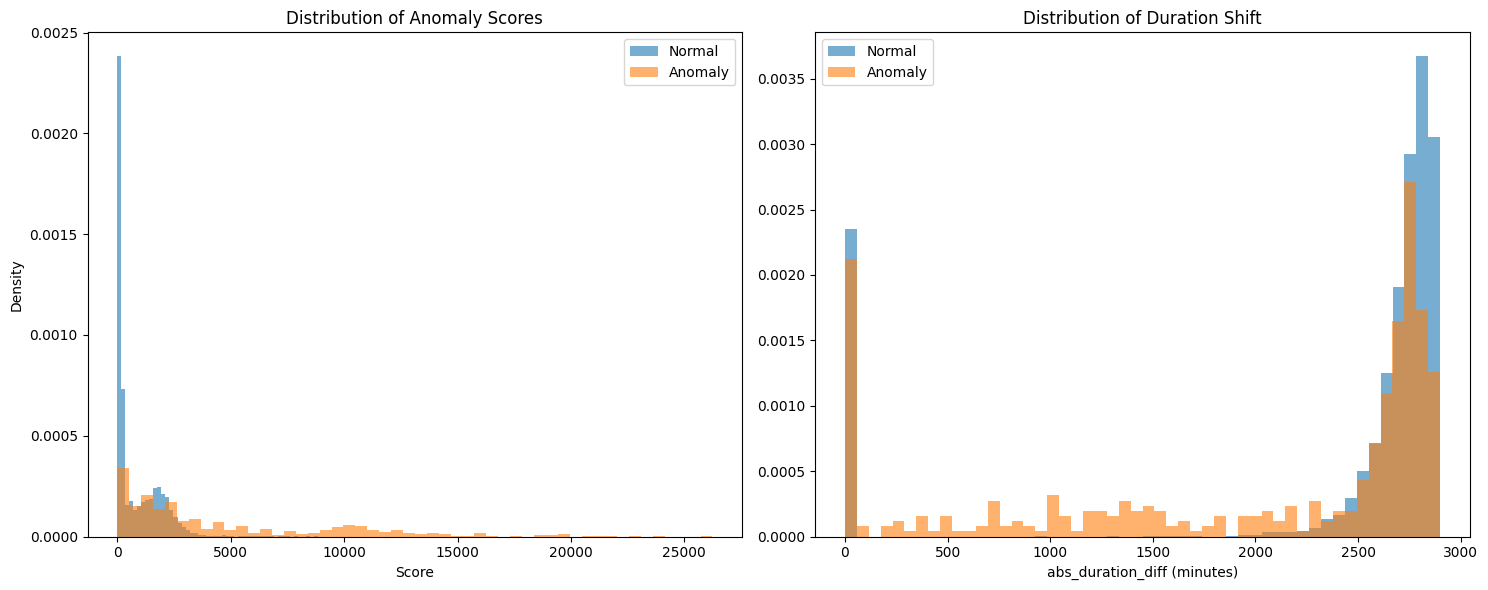

In [9]:
import matplotlib.pyplot as plt

# Data Prep
normal_scores  = anomaly_df[anomaly_df["is_anomaly"] == 0]["anomaly_score"]
anomaly_scores = anomaly_df[anomaly_df["is_anomaly"] == 1]["anomaly_score"]
diff_normal    = anomaly_df[anomaly_df["is_anomaly"] == 0]["difference"]
diff_anomaly   = anomaly_df[anomaly_df["is_anomaly"] == 1]["difference"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left Plot: Anomaly Scores
ax1.hist(normal_scores, bins=50, alpha=0.6, label="Normal", density=True)
ax1.hist(anomaly_scores, bins=50, alpha=0.6, label="Anomaly", density=True)
ax1.set_title("Distribution of Anomaly Scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Density")
ax1.legend()

# # Right Plot: Duration Diff (Split by Label)
ax2.hist(diff_normal, bins=50, alpha=0.6, label="Normal", density=True)
ax2.hist(diff_anomaly, bins=50, alpha=0.6, label="Anomaly", density=True)
ax2.set_title("Distribution of Duration Shift")
ax2.set_xlabel("abs_duration_diff (minutes)")
ax2.legend()

plt.tight_layout()
plt.show()

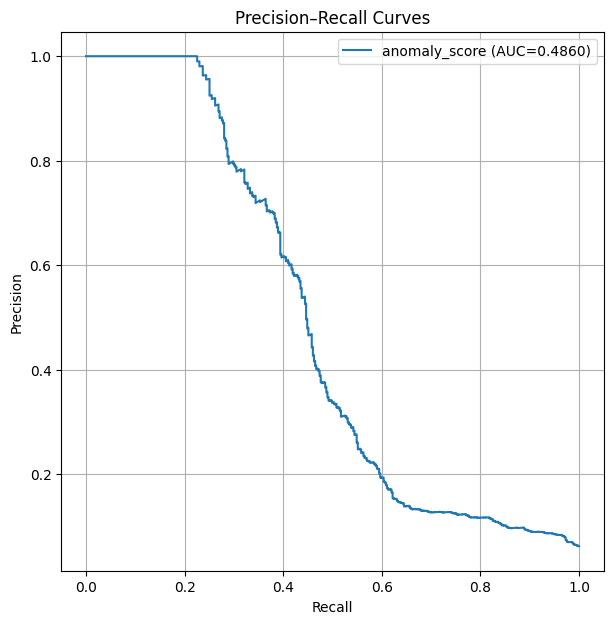

In [10]:
score_cols = [
    "anomaly_score"
]

y_true = anomaly_df["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in anomaly_df.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~anomaly_df[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        anomaly_df.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()